# Set up

In [1]:
import fastbook

fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

/home/tan/miniconda3/envs/handsonds/lib/python3.11/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


# Preparing Data

The data is downloaded using Bing Image Search API. You should replace `"XXX"` with your key if you wish to replicate this notebook's result.

In [2]:
key = os.environ.get("AZURE_SEARCH_KEY", "XXX")

In [3]:
results = search_images_bing(key, "dolphin", max_images=1)
image = results.attrgot("contentUrl")
len(image)

1

In [4]:
dolphin_image_path = Path("images/dolphin.jpg")
download_url((image[0]), dolphin_image_path)
dolphin_image_path

Path('images/dolphin.jpg')

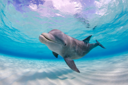

In [5]:
image = Image.open(dolphin_image_path)
image.to_thumb(128, 128)

Ok, look like it works great! Let's scale it up and download 150 images of dolphin and 150 images of blue whale.

In [6]:
animal_types = "dolphin", "blue whale"
path = Path("data")

In [7]:
if not path.exists():
    path.mkdir()
    for animal in animal_types:
        destination = path / animal
        destination.mkdir(exist_ok=True)
        results = search_images_bing(key, animal, max_images=300)
        download_images(destination, urls=results.attrgot("contentUrl"))

Our image files can be found at the `data` directory.

In [8]:
fns = get_image_files(path)
fns

(#273) [Path('data/dolphin/639b7abb-9461-4cbd-9ffb-3b2fe10fad9e.jpeg'),Path('data/dolphin/e13ec525-7bcc-4905-a1e2-3bb36316b5ea.jpg'),Path('data/dolphin/597c9d73-92d1-45c3-8047-3bb4100a4b1e.jpg'),Path('data/dolphin/ecef9f28-02a1-4b2f-bfeb-990e964abbad.jpg'),Path('data/dolphin/66bad492-7eb0-4cff-9080-121dcfb9185d.jpg'),Path('data/dolphin/a5177a13-2f4e-4212-b67b-1dee8eb9191e.jpg'),Path('data/dolphin/7505b7ac-aca8-4896-a8b1-54984bf39623.png'),Path('data/dolphin/3538ae85-a23c-4b05-b653-3cdd3ec165c5.jpg'),Path('data/dolphin/05472ed9-2108-47ef-9242-27b0033900ee.jpg'),Path('data/dolphin/f578a308-d189-488f-aa68-21fccb6446f8.jpg')...]

Since we download images from the Internet, a few file may be corrupted. You can check it using `verify_images()` function.

In [9]:
failed_images = verify_images(fns)
failed_images

(#0) []

And we can remove them using `unlink`.

In [10]:
failed_images.map(Path.unlink)

(#0) []

# Create the DataLoaders

In [33]:
data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
)

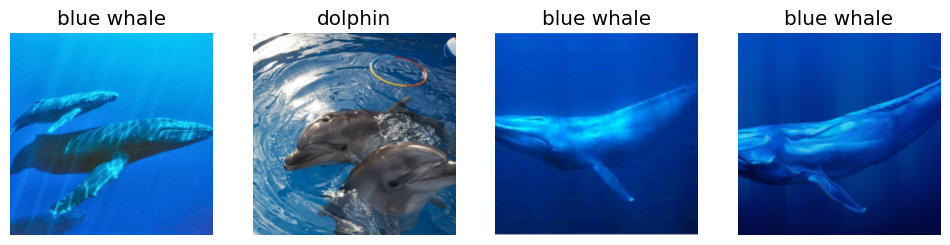

In [34]:
dls = data_block.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

# Adding Data Augmentation

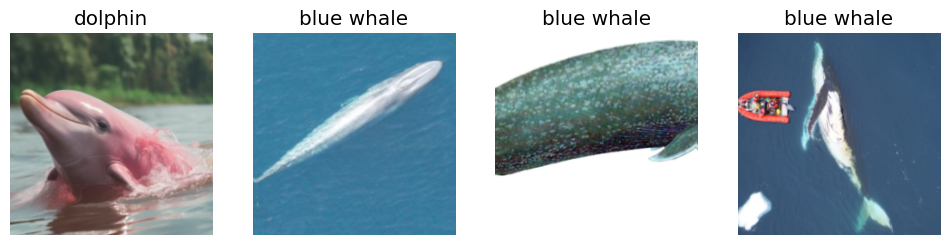

In [35]:
data_block = data_block.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms()
)
dls = data_block.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

# Train model and use it to clean the data

As you can see, some images are not actually contain a dolphin or blue whale: it may be about the evolution, or the food chain contain one of them, etc. So we need to get rid of those images.

However, go through each image file by file is exhausted, especially if there are thousands, or even more, images. What we will do is train a model and see which images need to be checked.

In [36]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.003758,0.592658,0.244898,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.525729,0.437903,0.142857,00:16
1,0.470702,0.318771,0.122449,00:16
2,0.444486,0.259527,0.061224,00:16
3,0.375462,0.213758,0.040816,00:16
4,0.326396,0.223486,0.061224,00:17
5,0.281388,0.246896,0.061224,00:17
6,0.239996,0.263449,0.061224,00:17
7,0.209685,0.278550,0.061224,00:17
8,0.182115,0.283867,0.061224,00:17
9,0.165295,0.286001,0.061224,00:17


Let's look at its confusion matrix.

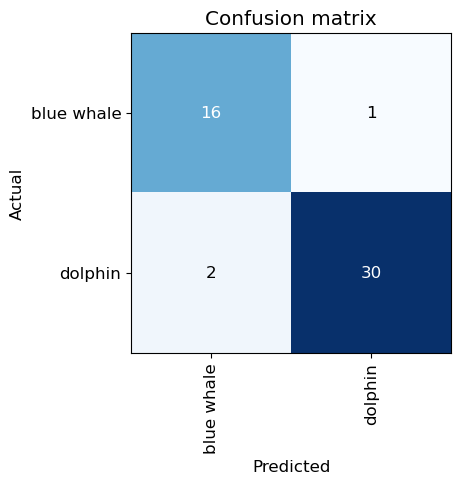

In [37]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

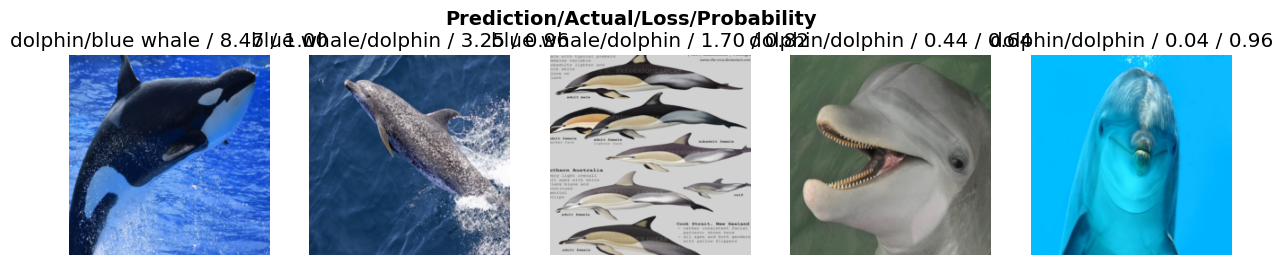

In [38]:
interpreter.plot_top_losses(5, nrows=1)

Look like the model mistakes the bibliography images with dolphin.

We'll use `ImageClassifierCleaner` to clean the data.

In [39]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [40]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
for idx, category in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path / category)

The model looks well enough. I don't think the cleaning could make anymore improvement, and the model is starting to overfitting.

# Export the model

In [41]:
learn.export()

You can find the export file at `export.pkl`.

In [42]:
path = Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]